# Binary Classification

## 1. Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('E:/PGP-DSE/Capstone Project/Group 2/OnlineNewsPopularity')

from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

In [2]:
df = pd.read_csv('ONPClass.csv')

In [3]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [4]:
df = df.drop(['url','timedelta'],axis=1)

# Importing libraries required for building models

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV, validation_curve,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score,roc_curve

## Custom functions

In [6]:

def std_data_whole(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled

def get_principal_comp(x_scaled):
    # Perfroming the PCA
    pca = PCA()
    pca.fit(x_scaled)

    # Apply dimensionality reduction - PCA to standardized X and get the principal components
    pc_score = pca.transform(X_scaled)

    # explained variance in percentage i.e (4.68/45)
    exp_var = pca.explained_variance_ratio_

    exp_var = np.round(exp_var*100,decimals=1)

    cum_var=np.cumsum(exp_var)

    return len(cum_var[cum_var<95])


def apply_pca(n,x_scaled):
    pca = PCA(n_components = n)
    data = pca.fit_transform(x_scaled)
    return data


def implement(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        final.update({'Model':names , 'auc_score': auc})
    return pd.DataFrame(final)



def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_, GS.best_estimator_, GS.best_score_


def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_


        
# ---------------------------------- extra ----------------------------------- #

def get_train_test_scores(x,y,models):
        names = []
        score1 = []
        score2 = []
        for name,model in models:
            kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
            output = cross_validate(model, x, y, cv = kfold, scoring = 'roc_auc', return_train_score = True)
            names.append(name)
            score1.append(np.mean(output['train_score']))
            score2.append(np.mean(output['test_score']))
        return pd.DataFrame({'Model': names, 'train_score': score1, 
                                 'test_score': score2})
    
                       
def get_imp_features(x,y,model):
        output = cross_validate(model, x, y, cv=5, scoring = 'roc_auc', return_estimator =True)
        for idx,estimator in enumerate(output['estimator']):
            print("Features sorted by their score for estimator {}:".format(idx))
            imp_feat = pd.DataFrame({'features': X.columns, 'imp_score':estimator.feature_importances_})
            imp_feat = imp_feat.sort_values(by = 'imp_score', ascending = False)
            print(imp_feat[imp_feat['imp_score']>0])
        print(output['test_score'],np.mean(output['test_score']))
        
        

def plot_roc_auc_curve(x,y,model,name):
    
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure(figsize=(5,5))
        i = 0
        
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        
        for train_index, test_index in kfold.split(x):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            probas_test = model.fit(X_train,y_train).predict_proba(X_test)[:,1]
            
            fpr, tpr, thresholds = roc_curve(y_test,probas_test)
            
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1
        print(thresholds)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),
                 lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title(r'Cross-Validation ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()
        
        

        
def plot_roc_auc_curve_all(x,y,models):
    
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure(figsize=(5,5))
        i = 0
        
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        for name,model,color in models:
            for train_index, test_index in kfold.split(x):
                X_train, X_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]

                probas_test = model.fit(X_train,y_train).predict_proba(X_test)[:,1]

                fpr, tpr, thresholds = roc_curve(y_test,probas_test)

                tprs.append(np.interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
                #plt.plot(fpr, tpr, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
                i += 1
                
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, color= color,
                     label=r'%s (AUC = %0.2f )' % (name,mean_auc),
                     lw=1, alpha=.6)
            
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance', alpha=.8)
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('Mean ROC for all models',fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

# ---------------------------------- extra ----------------------------------- #



## Applying PCA on whole data

In [7]:
X = df.drop(['class'], axis = 1 )

Y = df['class']

X_scaled = std_data_whole(X) # scale data

ncomp = get_principal_comp(X_scaled) # obtain principalcomponents

pca_data = apply_pca(ncomp,X_scaled) # apply pca on data

## Initialize and build the models


### 1. Logistic Regression

In [8]:

LOGREG = LogisticRegression(random_state = 0, max_iter = 1000)

models = []
models.append(('Logistic Regression',LOGREG))

implement(X_scaled,Y,models) # function call to fit the model with default parameters


,Model,auc_score
0,Logistic Regression,0.702458


### 2. Decision Tree

In [9]:

DT = DecisionTreeClassifier(random_state=0)

models = []
models.append(('Decision Tree', DT))

implement(X_scaled,Y,models) # default

,Model,auc_score
0,Decision Tree,0.57783


## Ensemble methods

### 3. Random Forest

In [8]:

RF = RandomForestClassifier(random_state=0)

models = []
models.append(('Random Forest', RF))


implement(X_scaled,Y,models) # default

,Model,auc_score
0,Random Forest,0.721993


### 4. AdaBoost DT

In [11]:

AB_DT = AdaBoostClassifier(base_estimator = DT, random_state=0)

models = []
models.append(('Decision Tree', DT))


implement(X_scaled,Y,models) # default

,Model,auc_score
0,Decision Tree,0.57783


### 5. AdaBoost RF

In [9]:

AB_RF = AdaBoostClassifier(base_estimator = RF, random_state=0)

models = []
models.append(('AB Random Forest', AB_RF))

implement(X_scaled,Y,models) # default

,Model,auc_score
0,AB Random Forest,0.720971


### 6. Gradient Boost 

In [13]:

GB = GradientBoostingClassifier(random_state=0)

models = []
models.append(('Gradient Boost', GB))

implement(X_scaled,Y,models) # default

,Model,auc_score
0,Gradient Boost,0.727489


## Hyper Parameter tuning - Random Search CV

### 1. Decision Tree

In [14]:
# Maximum number of levels in tree
max_depth = np.arange(2,9,2)

# Minimum number of samples required to split a node
min_samples_split = [2,3,5,7]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4,5]

dt_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
             'criterion':['gini','entropy'], 'min_samples_split' : min_samples_split}

dtparam, dtestimator, dtscore = random_search_cv(X_scaled,Y,DT,dt_params)

print(dtparam)

{'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 6, 'criterion': 'entropy'}


In [15]:
models = []
models.append(('Tuned Decision Tree', dtestimator))

implement(X_scaled,Y,models)

,Model,auc_score
0,Tuned Decision Tree,0.683426


## Ensemble Models with tuned parameters

### 2. Random Forest


In [18]:

# Number of trees in random forest
n_estimators = [10,15,20,25]

# Maximum number of levels in tree
max_depth =  np.arange(2,9,2)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5]


rf_params = {'n_estimators': n_estimators, 'criterion':['gini','entropy'], 
             'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split }

rfparam, rfestimator, rfscore = random_search_cv(X_scaled,Y,RF,rf_params)

print(rfparam)

{'n_estimators': 20, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 8, 'criterion': 'entropy'}


In [19]:
models = []
models.append(('Tuned Random Forest', rfestimator))

implement(X_scaled,Y,models)

,Model,auc_score
0,Tuned Random Forest,0.715076


### 3. AdaBoost RF

In [10]:
tuned_RF = RandomForestClassifier(n_estimators = 20, min_samples_split = 7, min_samples_leaf = 4, max_depth = 8,
                            criterion = 'entropy', random_state = 0)

AB_RF = AdaBoostClassifier(base_estimator = tuned_RF, n_estimators = 10, random_state = 0)

models = []
models.append(('AB RF', AB_RF))

implement(X_scaled,Y,models)

,Model,auc_score
0,AB RF,0.730976


### 4. AdaBoost DT

In [21]:
AB_DT = AdaBoostClassifier(base_estimator = dtestimator, n_estimators = 10, random_state = 0)

models = []
models.append(('AB DT', AB_DT))

implement(X_scaled,Y,models)

,Model,auc_score
0,AB DT,0.686979


### 5. Gradient Boost

In [26]:
GB = GradientBoostingClassifier(n_estimators = 50, random_state = 0)

models = []
models.append(('GB', GB))

implement(X_scaled,Y,models)

,Model,auc_score
0,GB,0.721613


## Inference: 

The hypertuned RF with AdaBoost perfroms well as compared to others with an roc_auc_score of 73.09% on PCA data

## Working on PCA Data -- with train test split

In [11]:

# function for splitting the data in train and validation set
def perform_train_test_split(x,y):
    return train_test_split(x, y, test_size=0.2, random_state = 0)



# function for scaling the data
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test



# function to Apply PCA on train and test sets
def get_principal_comp(train,test):
    
    # Perfroming the PCA
    pca = PCA(0.95)
    pca.fit(train)

    # Apply dimensionality reduction - PCA to standardized X and get the principal components
    pca_train = pca.transform(train)
    pca_test = pca.transform(test)
    
    # explained variance in percentage i.e (4.68/45)
    exp_var = pca.explained_variance_ratio_

    exp_var = np.round(exp_var*100,decimals=1)

    cum_var=np.cumsum(exp_var)
 
    print('No. of Components: ',len(cum_var[cum_var<95]))
    
    return pca_train, pca_test


# function to get roc_auc_scores for train and test  
def get_auc_scores(pca_train,pca_test,y_train,y_test,models):
    train_score = []
    test_score = []
    names = []
    for name, model in models:
        
        model.fit(pca_train,y_train)
        
        y_pred_train = model.predict(pca_train)
        y_pred_test = model.predict(pca_test)
        
        probas_train = model.predict_proba(pca_train)[:,1]
        probas_test = model.predict_proba(pca_test)[:,1]
    
        train_score.append(roc_auc_score(y_pred_train,probas_train))
        test_score.append(roc_auc_score(y_pred_test,probas_test))
        
        names.append(name)
        
        scores = pd.DataFrame({'Model': names, 'train_score': train_score, 'test_score': test_score})
        
        return scores

    

# function to plot the roc auc curve
def plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models):
    
    for name, model in models:
        
        model.fit(pca_train,y_train)
        
        y_pred_train = model.predict(pca_train)
        y_pred_test = model.predict(pca_test)
        
        print('For Train Data:\n')
        print(confusion_matrix(y_train,y_pred_train))
        print(classification_report(y_train,y_pred_train))
        
        print('For Test Data:\n')
        print(confusion_matrix(y_test,y_pred_test))
        print(classification_report(y_test,y_pred_test))
        
        probas_train = model.predict_proba(pca_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,probas_train)

        probas_test = model.predict_proba(pca_test)[:,1]
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test,probas_test)

        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_pred_train,probas_train)),lw=2, alpha=.5)
        plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_pred_test,probas_test)),lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()


        
# function for finding best parameters using RandomizedSearchCV  
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc',random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_


# function for finding best parameters using GridSearchCV
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_, GS.best_estimator_, GS.best_score_



# function to get roc_auc_score for each model using cross validation
def implement(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        final.update({'Model':names , 'auc_score': auc})
    return pd.DataFrame(final)



## Splitting the data into train and validation sets


In [12]:

X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity',
             'abs_title_subjectivity','weekday_is_friday'], axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y)           # split

scaled_train, scaled_test = std_data(X_train,X_test)                       # standardize data

pca_train, pca_test = get_principal_comp(scaled_train,scaled_test)         # apply pca

No. of Components:  32


## Initializing and Model Building

### 1. Logistic Regression

In [24]:
LOGREG = LogisticRegression(random_state = 0, max_iter = 1000)

models = []
models.append(('Logistic Regression',LOGREG))

In [25]:
get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,Logistic Regression,1.0,1.0


For Train Data:

[[10603  5424]
 [ 5875  9813]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     16027
           1       0.64      0.63      0.63     15688

    accuracy                           0.64     31715
   macro avg       0.64      0.64      0.64     31715
weighted avg       0.64      0.64      0.64     31715

For Test Data:

[[2667 1388]
 [1486 2388]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      4055
           1       0.63      0.62      0.62      3874

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



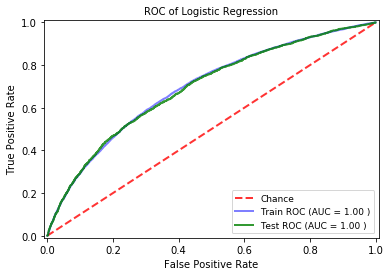

In [26]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 2. Descision Tree

In [27]:
DT = DecisionTreeClassifier(random_state = 0)

models = []
models.append(('DT', DT))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)


,Model,train_score,test_score
0,DT,1.0,1.0


For Train Data:

[[16027     0]
 [    0 15688]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16027
           1       1.00      1.00      1.00     15688

    accuracy                           1.00     31715
   macro avg       1.00      1.00      1.00     31715
weighted avg       1.00      1.00      1.00     31715

For Test Data:

[[2272 1783]
 [1688 2186]]
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      4055
           1       0.55      0.56      0.56      3874

    accuracy                           0.56      7929
   macro avg       0.56      0.56      0.56      7929
weighted avg       0.56      0.56      0.56      7929



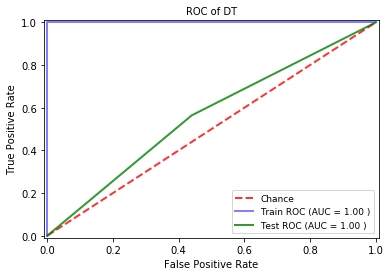

In [28]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

## Ensemble Models

### 3. Random Forest

In [29]:
RF = RandomForestClassifier(random_state = 0)

models = []
models.append(('RF', RF))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,RF,1.0,1.0


For Train Data:

[[16027     0]
 [    0 15688]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16027
           1       1.00      1.00      1.00     15688

    accuracy                           1.00     31715
   macro avg       1.00      1.00      1.00     31715
weighted avg       1.00      1.00      1.00     31715

For Test Data:

[[2687 1368]
 [1408 2466]]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4055
           1       0.64      0.64      0.64      3874

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



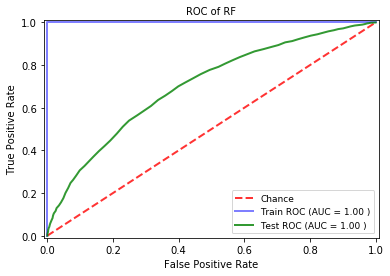

In [30]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 4. AdaBoost RF

In [32]:
AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 10, random_state = 0)

models = []
models.append(('AB RF', AB_RF))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,AB RF,1.0,1.0


For Train Data:

[[16027     0]
 [    0 15688]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16027
           1       1.00      1.00      1.00     15688

    accuracy                           1.00     31715
   macro avg       1.00      1.00      1.00     31715
weighted avg       1.00      1.00      1.00     31715

For Test Data:

[[2679 1376]
 [1469 2405]]
              precision    recall  f1-score   support

           0       0.65      0.66      0.65      4055
           1       0.64      0.62      0.63      3874

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



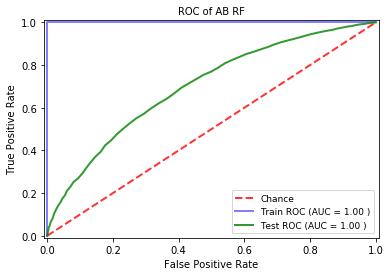

In [33]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 5. Adaboost DT

In [34]:
AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 10, random_state = 0)

models = []
models.append(('AB DT', AB_DT))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,AB DT,1.0,1.0


For Train Data:

[[16027     0]
 [    0 15688]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16027
           1       1.00      1.00      1.00     15688

    accuracy                           1.00     31715
   macro avg       1.00      1.00      1.00     31715
weighted avg       1.00      1.00      1.00     31715

For Test Data:

[[2280 1775]
 [1697 2177]]
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      4055
           1       0.55      0.56      0.56      3874

    accuracy                           0.56      7929
   macro avg       0.56      0.56      0.56      7929
weighted avg       0.56      0.56      0.56      7929



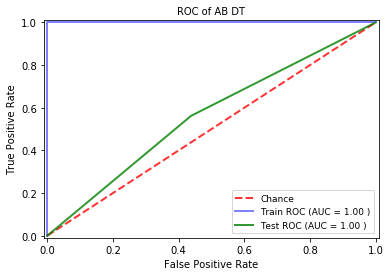

In [35]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 6. Gradient Boost

In [36]:
GB = GradientBoostingClassifier(n_estimators = 10, random_state = 0)

models = []
models.append(('GB', GB))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,GB,1.0,1.0


For Train Data:

[[10225  5802]
 [ 5779  9909]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     16027
           1       0.63      0.63      0.63     15688

    accuracy                           0.63     31715
   macro avg       0.63      0.63      0.63     31715
weighted avg       0.63      0.63      0.63     31715

For Test Data:

[[2510 1545]
 [1484 2390]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      4055
           1       0.61      0.62      0.61      3874

    accuracy                           0.62      7929
   macro avg       0.62      0.62      0.62      7929
weighted avg       0.62      0.62      0.62      7929



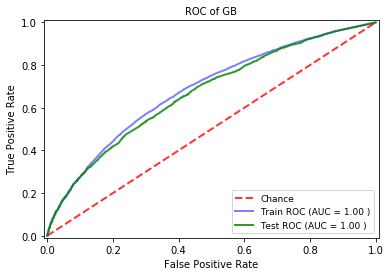

In [37]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

## Hyper Parameter tuning - Randomized Search CV

### 1. Decision Tree

In [38]:
# Maximum number of levels in tree
max_depth = np.arange(2,9,2)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4,5]

dt_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
             'criterion':['gini','entropy'], 'min_samples_split' : min_samples_split}

dtparam, dtestimator, dtscore = random_search_cv(pca_train,y_train,DT,dt_params)

print(dtparam)

{'min_samples_split': 9, 'min_samples_leaf': 5, 'max_depth': 8, 'criterion': 'entropy'}


In [39]:
models = []
models.append(('Tuned DT', dtestimator))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,Tuned DT,1.0,1.0


For Train Data:

[[10531  5496]
 [ 5354 10334]]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66     16027
           1       0.65      0.66      0.66     15688

    accuracy                           0.66     31715
   macro avg       0.66      0.66      0.66     31715
weighted avg       0.66      0.66      0.66     31715

For Test Data:

[[2461 1594]
 [1523 2351]]
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      4055
           1       0.60      0.61      0.60      3874

    accuracy                           0.61      7929
   macro avg       0.61      0.61      0.61      7929
weighted avg       0.61      0.61      0.61      7929



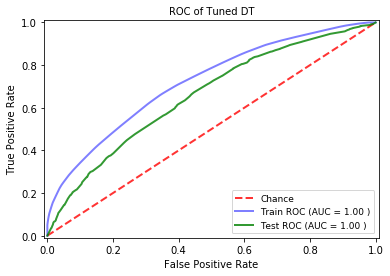

In [40]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

## Ensemble Models with tuned parameters

### 2. Random Forest

In [41]:
# Number of trees in random forest
n_estimators = np.arange(10,40,10)

# Maximum number of levels in tree
max_depth =  np.arange(2,9,2)
#[int(x) for x in np.linspace(3, 30, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5]


rf_params = {'n_estimators': n_estimators, 'criterion':['gini','entropy'], 
             'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split }

rfparam, rfestimator, rfscore = random_search_cv(pca_train,y_train,RF,rf_params)

print(rfparam)

{'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 8, 'criterion': 'gini'}


In [100]:
models = []
models.append(('Tuned RF', rfestimator))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,Tuned RF,1.0,1.0


For Train Data:

[[11362  4665]
 [ 5125 10563]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     16027
           1       0.69      0.67      0.68     15688

    accuracy                           0.69     31715
   macro avg       0.69      0.69      0.69     31715
weighted avg       0.69      0.69      0.69     31715

For Test Data:

[[2664 1391]
 [1427 2447]]
              precision    recall  f1-score   support

           0       0.65      0.66      0.65      4055
           1       0.64      0.63      0.63      3874

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



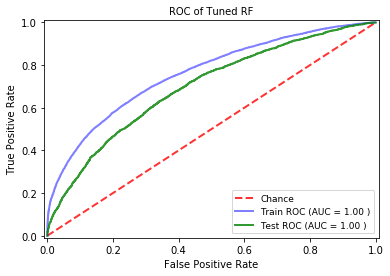

In [101]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 3. AdaBoost RF

In [102]:
AB_RF = AdaBoostClassifier(base_estimator = rfestimator, n_estimators = 15, random_state = 0)

models = []
models.append(('AB RF', AB_RF))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,AB RF,1.0,1.0


For Train Data:

[[14527  1500]
 [ 2435 13253]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     16027
           1       0.90      0.84      0.87     15688

    accuracy                           0.88     31715
   macro avg       0.88      0.88      0.88     31715
weighted avg       0.88      0.88      0.88     31715

For Test Data:

[[2720 1335]
 [1446 2428]]
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      4055
           1       0.65      0.63      0.64      3874

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



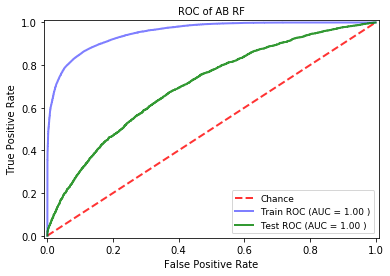

In [103]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 4. AdaBoost DT

In [104]:
AB_DT = AdaBoostClassifier(base_estimator = dtestimator, n_estimators = 10, random_state = 0)

models = []
models.append(('AB DT', AB_DT))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,AB DT,1.0,1.0


For Train Data:

[[11506  4521]
 [ 5165 10523]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.70     16027
           1       0.70      0.67      0.68     15688

    accuracy                           0.69     31715
   macro avg       0.69      0.69      0.69     31715
weighted avg       0.69      0.69      0.69     31715

For Test Data:

[[2632 1423]
 [1660 2214]]
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      4055
           1       0.61      0.57      0.59      3874

    accuracy                           0.61      7929
   macro avg       0.61      0.61      0.61      7929
weighted avg       0.61      0.61      0.61      7929



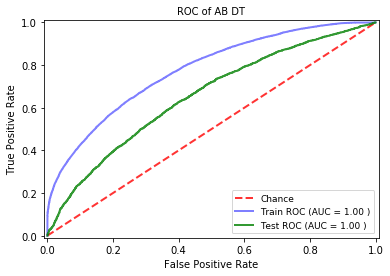

In [105]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

### 5. Gradient Boost

In [106]:
GB = GradientBoostingClassifier(n_estimators = 20, random_state = 0)

models = []
models.append(('GB', GB))

get_auc_scores(pca_train,pca_test,y_train,y_test,models)

,Model,train_score,test_score
0,GB,1.0,1.0


For Train Data:

[[ 9850  6177]
 [ 5266 10422]]
              precision    recall  f1-score   support

           0       0.65      0.61      0.63     16027
           1       0.63      0.66      0.65     15688

    accuracy                           0.64     31715
   macro avg       0.64      0.64      0.64     31715
weighted avg       0.64      0.64      0.64     31715

For Test Data:

[[2460 1595]
 [1306 2568]]
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      4055
           1       0.62      0.66      0.64      3874

    accuracy                           0.63      7929
   macro avg       0.64      0.63      0.63      7929
weighted avg       0.64      0.63      0.63      7929



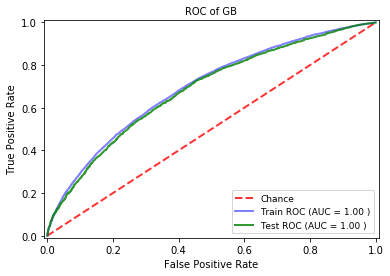

In [107]:
plot_roc_auc_curve(pca_train,pca_test,y_train,y_test,models)

## Inference:

Note : the data is split in the train test ratio of 80:20

the roc_auc_scores for each model remain the same as 1.

So, used 'Accuracy' as the evaluation metric.

from the above models it is observed that, the hypertuned RF with AdaBoost performs well having an accuracy of 65% on the test data

